In [0]:
import pandas as pd
import numpy as np

# FOR PLOTTING GRAPHS
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',300)

# LIBRARIES FOR THE RNN CLASSIFIER
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LSTM,Attention,Flatten,Activation,Permute,RepeatVector,Lambda,Multiply
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.backend import sum as Ksum

# FOR EVALUATION METRICS OF THE PREDICTIONS
from sklearn.metrics import accuracy_score,f1_score



In [0]:
import pickle

variables = pickle.load(open('./Data/variablesGlove','rb'))

test_sequence  = variables['test_sequence']
valid_sequence  = variables['valid_sequence']
train_sequence  = variables['train_sequence']

y_train  = variables['y_train']
y_test  = variables['y_test']
y_valid  = variables['y_valid']

MXSEQLEN  = variables['MXSEQLEN']
EMBEDDING_DIM  = variables['EMBEDDING_DIM']
train_embedding_weights  = variables['train_embedding_weights']
train_word_index  = variables['train_word_index']


In [0]:
#####################################################################################
########################## BUILDING AND TRAINING THE MODEL ##########################
#####################################################################################

def RNN(embedding_weights,num_words):
    
    # THE INPUT LAYER
    sequence_input      =   Input(shape=(MXSEQLEN,), dtype='int32')
    
    # THE EMBEDDING LAYER OF EMBEDDING_WEIGHTS     
    embedding_layer = Embedding(
        num_words,                  # VOCABULARY SIZE
        EMBEDDING_DIM,              # ONE HOT ENCODING VECTOR SIZE
        weights=[embedding_weights],# EMBEGGING WEIGHTS FROM THE GOOGLE NEW WORD VECTOR
        input_length=MXSEQLEN,      # MAX LENGTH OF A SEQUENCE
        trainable=False             # PARAMETERS WILL NOT BE TRAINED
    )
    
    # THE EMBEDDING SEQUENCES FROM THE EMBEDDING LAYER 
    embedded_sequences  =   embedding_layer(sequence_input)

    # ADDING ONE LSTM LAYER OF 256 NODES
    lstm_layer = LSTM(256)(embedded_sequences)   
    
    #ADDING ATTENTION LAYER
    units=256
    attention = Dense(1, activation='tanh')(lstm_layer)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute([2, 1])(attention)


    sent_representation = Multiply()([lstm_layer, attention])
    sent_representation = Lambda(lambda xin: Ksum(xin, axis=-2), output_shape=(units,))(sent_representation)


    # DENSE NEURON LAYER
    next_layer = Dense(128, activation='relu')(sent_representation)        
    
    # FEW DROPOUTS FOR AVOIDING OVERFIT
    next_layer = Dropout(0.4)(next_layer)                         

    # FINAL DENSE LAYER
    preds = Dense(1, activation='sigmoid')(next_layer)  

    model = Model(sequence_input, preds)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    
    model.summary()
    return model

In [6]:
# len= train_word_index +1 FOR 0 THAT WILL BE PADDED FOR COMPLETING THE SEQUENCE LENGTH
print(train_embedding_weights.shape)
rnn_model = RNN(train_embedding_weights, len(train_word_index)+1)

(3819, 300)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 300)      1145700     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256)          570368      embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            257         lstm[0][0]                       
__________________________________________________________________________________

In [11]:
# CONFIGURING AND TRAINING THE MODEL
EPOCHS = 7
BATCH_SIZE = 50

history = rnn_model.fit(
    train_sequence,       # THE INPUT SEQUENCES TO THE MODEL
    y_train,              # TARGET OUTPUT
    epochs=EPOCHS,    
    validation_data=(valid_sequence, y_valid), 
    shuffle=True, 
    batch_size=BATCH_SIZE
)

Epoch 1/7
170/170 [==============================] - 67s 394ms/step - loss: 0.0569 - acc: 0.9791 - val_loss: 0.3849 - val_acc: 0.9076
Epoch 2/7
170/170 [==============================] - 66s 389ms/step - loss: 0.0394 - acc: 0.9861 - val_loss: 0.4802 - val_acc: 0.9052
Epoch 3/7
170/170 [==============================] - 72s 423ms/step - loss: 0.0332 - acc: 0.9872 - val_loss: 0.5117 - val_acc: 0.8944
Epoch 4/7
170/170 [==============================] - 66s 388ms/step - loss: 0.0269 - acc: 0.9885 - val_loss: 0.6265 - val_acc: 0.8992
Epoch 5/7
170/170 [==============================] - 67s 395ms/step - loss: 0.0265 - acc: 0.9895 - val_loss: 0.5817 - val_acc: 0.8980
Epoch 6/7
170/170 [==============================] - 67s 391ms/step - loss: 0.0191 - acc: 0.9911 - val_loss: 0.6444 - val_acc: 0.9076
Epoch 7/7
170/170 [==============================] - 66s 390ms/step - loss: 0.0152 - acc: 0.9919 - val_loss: 0.6880 - val_acc: 0.9064


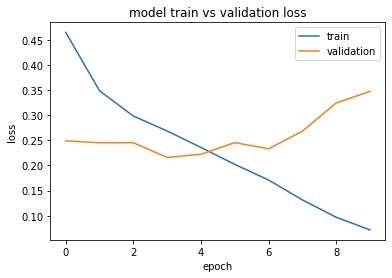

In [8]:
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
predict=rnn_model.predict(test_sequence)
predict=[int(x+0.5) for x in predict]

In [10]:
# EVLUATING THE ACCURACY
accuracy = accuracy_score(y_test, predict)
f1=f1_score(y_test,predict)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

F1 Score: 73.55%
Accuracy: 76.18%
